In [50]:
from dotenv import load_dotenv
load_dotenv()
import os
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

connecting to mysql database

In [51]:
conn = mysql.connector.connect(
    host = os.getenv("DB_HOST"),
    user = os.getenv("DB_USER"),
    password = os.getenv("DB_PASSWORD"),
    database = os.getenv("DB_NAME"),
    port = 3306
)

df = pd.read_sql_query("SHOW DATABASES;", conn)

C:\Users\Bryant\AppData\Local\Temp\ipykernel_4572\2674420896.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SHOW DATABASES;", conn)


# Exploring data and checking for null values before analyzing/aggregating

Checking contents of table and data types

Creating dataframe from sql table to check contents of data

In [52]:
query_df = "SELECT * FROM zara "
df = pd.read_sql_query(query_df, conn)

C:\Users\Bryant\AppData\Local\Temp\ipykernel_4572\1106526662.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query_df, conn)


Checking data types of columns and if null values exist

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product ID        252 non-null    int64  
 1   Product Position  252 non-null    object 
 2   Promotion         252 non-null    object 
 3   Product Category  252 non-null    object 
 4   Seasonal          252 non-null    object 
 5   Sales Volume      252 non-null    int64  
 6   brand             252 non-null    object 
 7   url               252 non-null    object 
 8   sku               252 non-null    object 
 9   name              252 non-null    object 
 10  description       252 non-null    object 
 11  price             252 non-null    float64
 12  currency          252 non-null    object 
 13  scraped_at        252 non-null    object 
 14  terms             252 non-null    object 
 15  section           252 non-null    object 
dtypes: float64(1), int64(2), object(13)
memory u

In [54]:
df.isnull().sum()

Product ID          0
Product Position    0
Promotion           0
Product Category    0
Seasonal            0
Sales Volume        0
brand               0
url                 0
sku                 0
name                0
description         0
price               0
currency            0
scraped_at          0
terms               0
section             0
dtype: int64

# Analyzing/aggregating Data

## Question 1: Which type of products generate the most revenue?

Checking clothing items that zara sells

In [55]:
query_product = """SELECT DISTINCT terms
                   FROM zara"""
df_product = pd.read_sql_query(query_product, conn)
print(df_product)

      terms
0   jackets
1     shoes
2  sweaters
3     jeans
4  t-shirts


C:\Users\Bryant\AppData\Local\Temp\ipykernel_4572\909039282.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_product = pd.read_sql_query(query_product, conn)


Determining revenue for each type of product 

In [56]:
query_revenue = """SELECT terms, SUM(price * `Sales Volume`) as revenue
                    FROM zara
                    GROUP BY terms
                    ORDER BY revenue DESC"""
df_revenue = pd.read_sql_query(query_revenue, conn)
print(df_revenue)

      terms      revenue
0   jackets  26581815.87
1  sweaters   4090631.48
2     shoes   3754837.63
3  t-shirts   3696806.25
4     jeans    864385.25


C:\Users\Bryant\AppData\Local\Temp\ipykernel_4572\3366098796.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_revenue = pd.read_sql_query(query_revenue, conn)


Graphing results of query, a bar plot seems best fit as the data is categorical vs numerical. The ticks on the y-axis are manually set for clarity purposes.

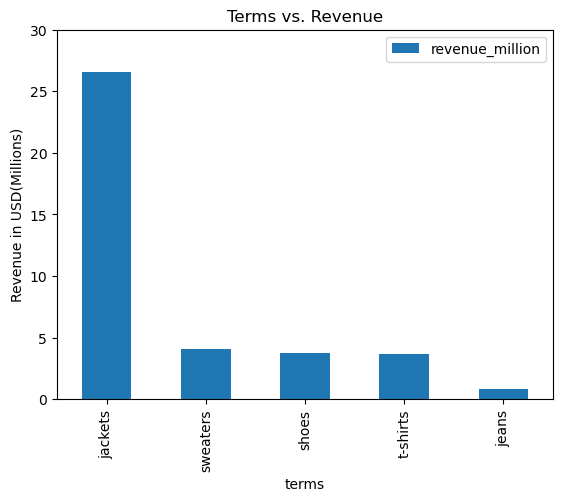

In [57]:
df_revenue["revenue_million"] = df_revenue["revenue"] / 1_000_000
axes = df_revenue.plot.bar(x = "terms", y = "revenue_million", title = "Terms vs. Revenue")
axes.set_ylabel("Revenue in USD(Millions)")
axes.set_yticks(np.arange(0, 31, 5));

**Insights:** Based on the graph, a majority of the revenue at zara comes from selling jackets(\~26.6 million USD). Sweaters, shoes, and t-shirts contribute roughly the same revenue(\~3.7-4.1 million USD). Jeans generated the least amount of revenue(\~0.87 million USD).

## Question 2: Do products on promotion sell more than non-promoted products?

inspecting 'promotion' column to see its data contents

In [58]:
query_inspect_promotion = """SELECT DISTINCT promotion
                        FROM zara"""
df_inspect_promotion = pd.read_sql_query(query_inspect_promotion, conn)
print(df_inspect_promotion)

  promotion
0        No
1       Yes


C:\Users\Bryant\AppData\Local\Temp\ipykernel_4572\2880099132.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_inspect_promotion = pd.read_sql_query(query_inspect_promotion, conn)


In [59]:
print(list(df.columns.values))

['Product ID', 'Product Position', 'Promotion', 'Product Category', 'Seasonal', 'Sales Volume', 'brand', 'url', 'sku', 'name', 'description', 'price', 'currency', 'scraped_at', 'terms', 'section']


Thought process now is to create a query that returns the sum, total count, and average sales of all promoted and non-promoted items, then group by promotion. The total count and net sales will provide some background into whether Zara has more promoted or non-promoted items. The average sales volume of each promotion type will ultimately let us make an insight into whether promoted items sell more than non-promoted items.

In [60]:
query_promotion = """SELECT promotion, 
                        COUNT(*) as count, 
                        SUM(`Sales Volume`) as sales, 
                        AVG(`Sales Volume`) as average_sales
                        FROM zara
                        GROUP BY promotion"""
df_promotion = pd.read_sql_query(query_promotion, conn)
print(df_promotion)

  promotion  count     sales  average_sales
0        No    132  240312.0      1820.5455
1       Yes    120  219261.0      1827.1750


C:\Users\Bryant\AppData\Local\Temp\ipykernel_4572\3327727472.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_promotion = pd.read_sql_query(query_promotion, conn)


**Insights:** The average sales volume for non promoted items was ~1820.55, while the average sales volume for promoted items was ~1827.18. Based on this, we can infer that promoted items do sell more than non-promoted items by approximately 7 units on average. This difference is very small, however, so putting items on promotion may not be highly beneficial.

## Question 3: Does product position influence sales, and does product promotion amplify this?

first going to inspect 'product position' column and see what data it holds

In [61]:
query_inspect_position = """ SELECT DISTINCT `Product Position` 
                                FROM zara"""
df_inspect_position = pd.read_sql_query(query_inspect_position, conn)
print(df_inspect_position)

  Product Position
0            Aisle
1          End-cap
2   Front of Store


C:\Users\Bryant\AppData\Local\Temp\ipykernel_4572\3936033665.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_inspect_position = pd.read_sql_query(query_inspect_position, conn)


Now that we know that there's three types of product positions, we can create a query that utilizes "group by" for each product position and then returns the sum, count, and the mean sales volume. The average sales volume will help us determine if product position influences sales.

In [62]:
query_position = """SELECT `Product Position`,
                    COUNT(*) as count, 
                    SUM(`Sales Volume`) as sales, 
                    AVG(`Sales Volume`) as average_sales
                    FROM zara
                    GROUP BY `Product Position`
                    """
df_position = pd.read_sql_query(query_position, conn)
print(df_position)

  Product Position  count     sales  average_sales
0            Aisle     97  177396.0      1828.8247
1          End-cap     86  152930.0      1778.2558
2   Front of Store     69  129247.0      1873.1449


C:\Users\Bryant\AppData\Local\Temp\ipykernel_4572\1862260906.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_position = pd.read_sql_query(query_position, conn)


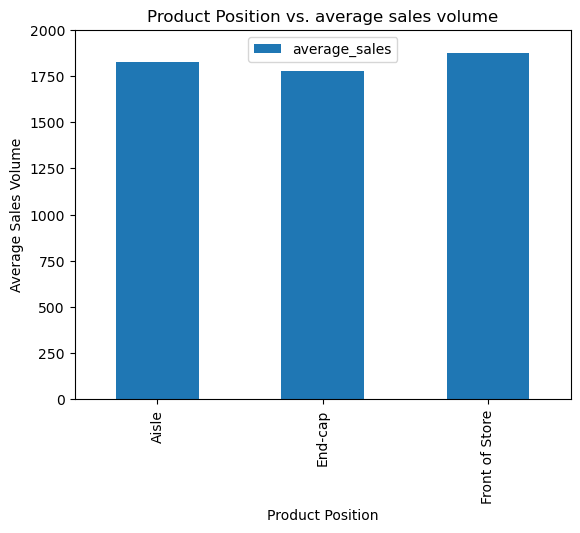

In [63]:
position_graph = df_position.plot.bar(x = "Product Position", y = "average_sales", title = "Product Position vs. average sales volume")
position_graph.set_ylabel("Average Sales Volume")
position_graph.set_yticks(np.arange(0, 2001, 250));

**Insights:** Items sold at the front of the store had an average sales volume of roughly 1873 units, end-cap items sold an average of 1778 units, while items in an aisle had a mean sales volume of 1828 units. Based on the graph above, we can see that items in a particular location of the store will not drastically affect the average sales volume of those items compared to the rest of the locations.

Now we can determine if the status of item promotion amplifies the average sales volume. This can be done through using 'GROUP BY' on both the 'promotion' column and 'product position' column. The query will return all combinations of product position and product promotion, which will let us see if promoted items will increase or decrease sales volume with respect to product location.

In [64]:
query_position_on_promotion ="""SELECT `Product Position`,
                                Promotion,
                                COUNT(*) as count,
                                SUM(`Sales Volume`) as sales,
                                AVG(`Sales Volume`) as average_sales
                                FROM zara
                                GROUP BY `Product Position`, Promotion
                                ORDER BY `Product Position`
                                """
df_position_on_promotion = pd.read_sql_query(query_position_on_promotion, conn)
print(df_position_on_promotion)

  Product Position Promotion  count    sales  average_sales
0            Aisle        No     51  94937.0      1861.5098
1            Aisle       Yes     46  82459.0      1792.5870
2          End-cap        No     44  74374.0      1690.3182
3          End-cap       Yes     42  78556.0      1870.3810
4   Front of Store        No     37  71001.0      1918.9459
5   Front of Store       Yes     32  58246.0      1820.1875


C:\Users\Bryant\AppData\Local\Temp\ipykernel_4572\1398448371.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_position_on_promotion = pd.read_sql_query(query_position_on_promotion, conn)


In order to get a clearer understanding of the data, a graph would help significantly. A bar graph seems best fit as we could see side-by-side the difference(s) that items being on promotion may have. *Because we also want our columns to separate items based on if they're on promotion or not, pivoting the dataframe will make graphing it easier.*

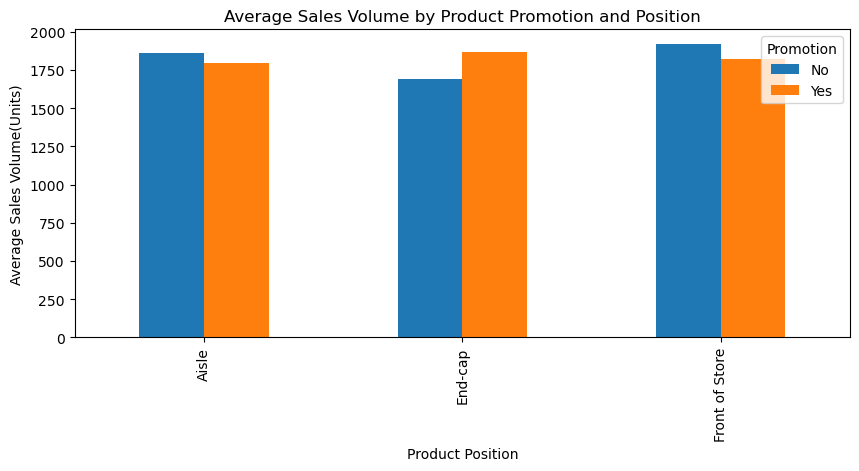

In [65]:
pivot_df = df_position_on_promotion.pivot(index = "Product Position", columns = "Promotion", values = "average_sales")
bar_graph = pivot_df.plot.bar(figsize=(10,4))
bar_graph.set_title("Average Sales Volume by Product Promotion and Position")
bar_graph.set_ylabel("Average Sales Volume(Units)")
plt.show()

**Insights**: Items located in an aisle and on promotion had sold less volume, on average, than those of non promoted items in an aisle by ~70 units. promoted items in the front of the store also had lower mean volume sales by approximately 98 units. The only location in the store where the promoted items mean sales volume was more than non-promoted items was on an end-cap, which saw an increase in average sales volume by ~180 units. Based on the graph, only promoted clothing items that were on an end-cap saw an increase in average sales volume compared to non-promoted clothing items in the same location. Ultimately, promotions did not increase average sales volume in most locations.

## FINAL INSIGHTS: 
- Jackets are by far the most sold clothing item at Zara
- Item on promotion have a slightly higher mean sales volume than non-promoted items
- The front of the store had the highest average sales volume
- the only location where promotions increase sales volume compared to non promoted items is on an end-cap